In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
import pymc3 as pm
import arviz as az
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
#import covid19_inference as cov19
from header_plotting import *


In [2]:
%load_ext autoreload
%autoreload 2

In [111]:
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig_path = "../figures/SI"

xlim_ts = [ # Plotting x lims
    datetime.datetime(2021,5,30),
    datetime.datetime(2021,7,23)
] 

def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
        
countries = ['England', 'Czechia']

traces,traces_without_soccer,traces_primary_soccer, models, dls = [], [], [], [],[]
for country in tqdm(countries):
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(fstr(tune, draws, max_treedepth), " not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)
    
    trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_data/primary_and_subsequent/{country}.pkl")

    traces_without_soccer.append(trace_without_soccer)
    traces_primary_soccer.append(trace_primary_soccer)

  0%|          | 0/2 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 4000 sample runs for Czechia


## England without final but only groupstage


In [4]:
df = pd.read_csv("../../data/em_game_data.csv",header=2)
#df = df[~df["id"].str.contains("a")] # Filter extra games we added for validation these are suffixed with a
df[" date"]= pd.to_datetime(df[" date"])
df

,id,date,phase,team1,team2,goals1,goals2,location
0,000,2021-06-11,GS,TR,IT,0,3,Rome
1,001,2021-06-12,GS,GB-WLS,CH,1,1,Baku
2,002,2021-06-12,GS,DK,FI,0,1,Copenhagen
3,003,2021-06-12,GS,BE,RU,3,0,Saint Petersburg
4,004,2021-06-13,GS,GB-ENG,HR,1,0,London
5,005,2021-06-13,GS,AT,MK,3,1,Bucharest
6,006,2021-06-13,GS,NL,UA,3,2,Amsterdam
7,007,2021-06-14,GS,GB-SCT,CZ,0,2,Glasgow
8,008,2021-06-14,GS,PL,SK,1,2,Saint Petersburg
9,009,2021-06-14,GS,ES,SE,0,0,Seville


In [127]:
import arviz as az
import pymc3 as pm
import copy


# Edit england trace to non groupphase games to 0 percent
def get_samples_no_groupstage(orig_trace,orig_model,orig_dl,var_names=["new_E_t","new_cases",]):
    """ Remove non group phase effects and
        get posterior predictive samples from new trace.
        
        Parameters
        ----------
        orig_trace:
            Original trace
        orig_model:
            Original model
        orig_dl:
            Original dataloader
        var_names:
            Variable names to sample
    """
    
    # Mask for groupstage game
    iso2 = orig_dl.countries_iso2[0]
    df = pd.read_csv("../../data/em_game_data.csv",header=2)
    t = df[df[' team1'].str.contains(iso2) | df[' team2'].str.contains(iso2)]
    mask_no_GS = ~(t[" phase"].str.contains("GS"))
    
    # Edit original trace
    trace_no_GS = copy.deepcopy(orig_trace)
    trace_no_GS.posterior["Delta_alpha_g_sparse"][:,:,mask_no_GS] = trace_no_GS.posterior["Delta_alpha_g_sparse"][:,:,mask_no_GS]*0
    
    # Sample posterior predictive
    ret_trace = pm.fast_sample_posterior_predictive(
        trace_no_GS,
        model=orig_model,
        var_names=var_names,
        keep_size=True,
    )
    return az.from_pymc3_predictions(ret_trace), trace_no_GS


In [9]:
prediction_no_GS, trace_no_GS = get_samples_no_groupstage(traces[0],models[0],dls[0])

# Save
with open(f"/data.nst/smohr/covid19_soccer_data/counterfactual/England_only_group_stage.pkl", "wb") as f:
    pickle.dump((prediction_no_GS,trace_no_GS), f)

ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/smohr/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [6]:
prediction_no_GS, trace_no_GS = load("/data.nst/smohr/covid19_soccer_data/counterfactual/England_only_group_stage.pkl")

In [40]:
from utils import getNoSoccer, getPrimary
# Sample noSoccer and primarySoccer
trace_no_GS.posterior["new_E_t"] = (trace_no_GS.posterior["new_E_t"].dims,prediction_no_GS.predictions["new_E_t"].values[0,...])
trace_no_GS.posterior["new_cases"] = (trace_no_GS.posterior["new_cases"].dims,prediction_no_GS.predictions["new_cases"].values[0,...])

trace_no_GS_no_soccer = getNoSoccer(trace_no_GS,models[0])
trace_no_GS_primary = getPrimary(trace_no_GS,trace_no_GS_no_soccer,models[0],dls[0])

ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/smohr/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
INFO     [covid19_soccer.utils] pr_sigma_lambda was set to default value 0.2
INFO     [covid19_soccer.utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_soccer.delay_by_weekday] Delaying cases by weekday
ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/smohr/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from

## England but with incidence anddimsbase from Czechia

In [128]:
from covid19_soccer.models import create_model_gender

def get_samples_czechia_with_England_participation(
    orig_trace, orig_model, orig_dl,
    participation_trace, participation_model, participation_dl,
    var_names=["new_E_t","new_cases","R_soccer"]
):
    """ Overwrite a trace with base from another one
        get posterior predictive samples from new trace.
        
        Parameters
        ----------
        orig_trace:
            Original trace
        orig_model:
            Original model
        orig_dl:
            Original dataloader
        overwrite_trace:
            Trace which is used to overwrite values in org
        overwrite_model:
        overwrite_dl:
        var_names:
            Variable names to sample
    """
    
    # Create model with new alpha_prior
    new_model = create_model_gender(
        dataloader=orig_dl,
        beta=False,
        force_alpha_prior=participation_dl.alpha_prior[0, :]
    )
    
    # Overwrite Delta_alpha_g_sparse
    new_trace = copy.deepcopy(participation_trace)
    for key in list(participation_trace.posterior.data_vars):
        if "Delta_alpha_g_sparse" in key or "alpha_mean" in key or "sigma_alpha_g" in key:
            continue
        else:
            new_trace.posterior[key] = orig_trace.posterior[key]
    new_trace.posterior["Delta_alpha_g_sparse"] = (
        new_trace.posterior["Delta_alpha_g_sparse"].dims,
        np.ones((new_trace.posterior["Delta_alpha_g_sparse"].shape[0],new_trace.posterior["Delta_alpha_g_sparse"].shape[1]))[...,None]*(
            new_trace.posterior["Delta_alpha_g_sparse"].mean(axis=(0,1)).values +
            new_trace.posterior["alpha_mean"].mean().values
        )
    )
    new_trace.posterior["alpha_mean"] = (
        new_trace.posterior["alpha_mean"].dims,
        np.zeros((new_trace.posterior["alpha_mean"].shape[0],new_trace.posterior["alpha_mean"].shape[1]))
    )
    
    print(new_trace.posterior["alpha_mean"].mean(axis=(0,1)))
    print(new_trace.posterior["Delta_alpha_g_sparse"].mean(axis=(0,1)))
    # As the dimensions of the alpha_g sparse vector might not match we use the participation_model here
    ret_trace = pm.fast_sample_posterior_predictive(
        new_trace,
        model=new_model,
        var_names=var_names,
        keep_size=True,
    )
    return az.from_pymc3_predictions(ret_trace), new_trace

In [123]:
print(traces[1].posterior["Delta_alpha_g_sparse"].mean(axis=(0,1)).values)
print(traces[1].posterior["alpha_mean"].mean(axis=(0,1)).values)

[-0.74815998 -0.75656947  0.38167942  0.32488271  0.91275244]
1.2804101560453673


In [129]:
prediction_czechia_with_england_participation, trace_czechia_with_england_participation = get_samples_czechia_with_England_participation(
    traces[1],models[1],dls[1],
    traces[0],models[0],dls[0]
)


INFO     [covid19_soccer.utils] pr_sigma_lambda was set to default value 0.2
INFO     [covid19_soccer.utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_soccer.effect_gender] R_t_soccer with deltas
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_E
INFO     [covid19_soccer.compartmental_models] kernelized spread soccer
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_soccer.delay_by_weekday] Delaying cases by weekday


<xarray.DataArray 'alpha_mean' ()>
array(0.)
<xarray.DataArray 'Delta_alpha_g_sparse' (Delta_alpha_g_sparse_dim_0: 7)>
array([-0.20642792,  0.5734683 ,  0.19657873,  1.03930229,  0.58268348,
        0.82290522,  2.49293175])
Coordinates:
  * Delta_alpha_g_sparse_dim_0  (Delta_alpha_g_sparse_dim_0) int64 0 1 2 3 4 5 6


KeyError: 'R_soccer'

In [ ]:
def get_samples_with_cases_and_R_from_second_trace(
    orig_trace, orig_model, orig_dl,
    overwrite_trace, overwrite_model, overwrite_dl,
    var_names=["new_E_t","new_cases"]
):
    """ Overwrite a trace with base from another one
        get posterior predictive samples from new trace.
        
        Parameters
        ----------
        orig_trace:
            Original trace
        orig_model:
            Original model
        orig_dl:
            Original dataloader
        overwrite_trace:
            Trace which is used to overwrite values in org
        overwrite_model:
        overwrite_dl:
        var_names:
            Variable names to sample
    """
    
    # 1. Overwrite R_base i.e. all lambda cps
    new_trace = copy.deepcopy(orig_trace)
    for key in list(orig_trace.posterior.data_vars):
        if "lambda" in key or "transient" in key or "I_begin" in key:
            new_trace.posterior[key] = overwrite_trace.posterior[key]
        if key == "I_begin_ratio_log_L2_raw":
            new_trace.posterior[key] = (
                overwrite_trace.posterior[key] + 1.0/ overwrite_trace.posterior["sigma_I_begin_ratio_log_L1"].values[...,None] * np.log(
                    np.nansum(overwrite_model.new_cases_obs[:5], axis=0) /
                    np.nansum(orig_model.new_cases_obs[:5], axis=0) 
                )
            )

    # 2. Sample posterior predictive
    ret_trace = pm.fast_sample_posterior_predictive(
        new_trace,
        model=orig_model,
        var_names=var_names,
        keep_size=True,
    )
    return az.from_pymc3_predictions(ret_trace), new_trace

In [30]:
prediction_czechia_with_england_participation, trace_czechia_with_england_participation = get_samples_with_cases_and_R_from_second_trace(
    traces[0],models[0],dls[0],
    traces[1],models[1],dls[1]
)

# Save
with open(f"/data.nst/smohr/covid19_soccer_data/counterfactual/Czechia_with_England_participation.pkl", "wb") as f:
    pickle.dump((prediction_czechia_with_england_participation,trace_czechia_with_england_participation), f)

ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/smohr/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [ ]:
from utils import getNoSoccer, getPrimary
# Sample noSoccer and primarySoccer
trace_czechia_with_england_participation.posterior["new_E_t"] = (trace_czechia_with_england_participation.posterior["new_E_t"].dims,prediction_czechia_with_england_participation.predictions["new_E_t"].values[0,...])
trace_czechia_with_england_participation.posterior["new_cases"] = (trace_czechia_with_england_participation.posterior["new_cases"].dims,prediction_czechia_with_england_participation.predictions["new_cases"].values[0,...])

trace_czechia_with_england_participation_no_soccer = getNoSoccer(trace_czechia_with_england_participation,models[0])
trace_czechia_with_england_participation_primary = getPrimary(trace_czechia_with_england_participation,trace_czechia_with_england_participation_no_soccer,models[0],dls[0])

## Plotting

In [64]:
def get_xy(trace,trace_without_soccer,trace_primary_soccer):
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    x = pd.date_range(model.sim_begin, model.sim_end)
    y0 = trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0)
    y1 = trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0) - y0
    y2 = trace.posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0) - y1 - y0
    
    y = [
        y0[:,0]+y0[:,1],
        y1[:,0]+y1[:,1],
        y2[:,0]+y2[:,1]
    ]
    return x, y

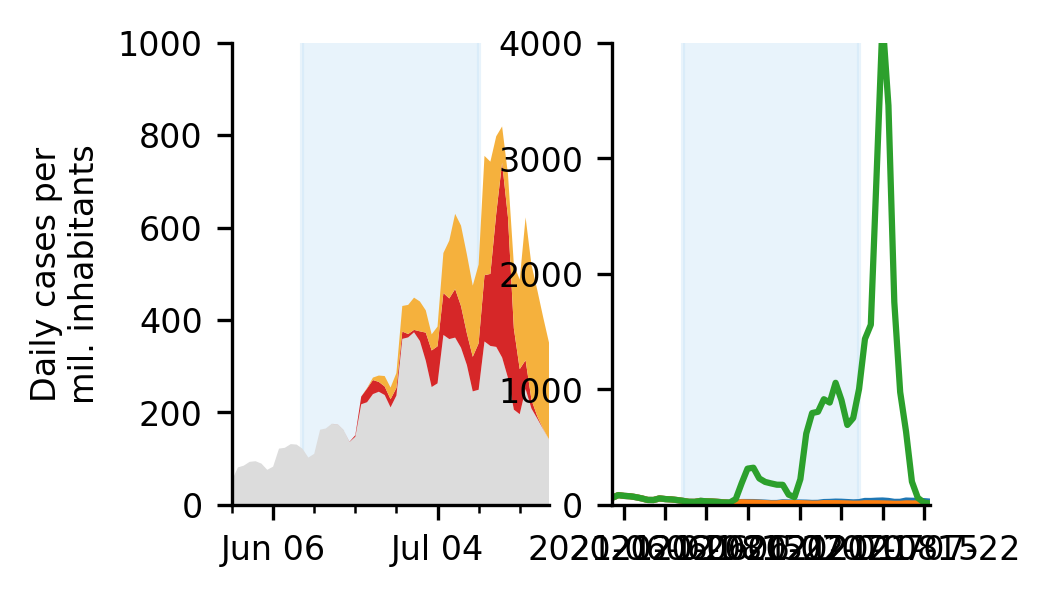

In [106]:
## Plotting
from covid19_soccer.plot.timeseries import _uefa_range, incidence, stacked_filled, fraction_male_female, _timeseries, format_date_axis


fig, axes = plt.subplots(1,2,figsize=(3,2))
colors_base = ["gainsboro","tab:red","#f5b13d"]

x, y = get_xy(trace_no_GS,trace_no_GS_no_soccer,trace_no_GS_primary)
for j in range(len(y)):
    y[j] = y[j]/dls[0].population[0]*1e6
    
_uefa_range(axes[0])
stacked_filled(
    x,
    [yi/2 for yi in y],
    ax=axes[0],
    colors=colors_base,
    label="b",
)
axes[0].set_ylim(0,1000)
axes[0].set_ylabel("Daily cases per\nmil. inhabitants")
axes[0].set_xlim(*xlim_ts)


x, y = get_xy(
    trace_czechia_with_england_participation,
    trace_czechia_with_england_participation_no_soccer,
    trace_czechia_with_england_participation_primary
)

for j in range(len(y)):
    y[j] = y[j]/np.sum(dls[1].population[0])*1e6

_uefa_range(axes[1])
"""
stacked_filled(
    x,
    [yi/2 for yi in y],
    ax=axes[1],
    colors=colors_base,
    label="b",
)
"""
axes[1].set_ylim(0,4000)
#axes[1].set_ylabel("Daily cases per\nmil. inhabitants")
axes[1].set_xlim(*xlim_ts)

nc = get_from_trace("new_cases",trace_czechia_with_england_participation)
axes[1].plot(x,nc.sum(axis=-1).mean(axis=0)/np.sum(dls[1].population[0])*1e6)

nc = get_from_trace("new_cases",trace_czechia_with_england_participation_no_soccer,from_type="predictions")
axes[1].plot(x,nc.sum(axis=-1).mean(axis=0)/np.sum(dls[1].population[0])*1e6)

nc = get_from_trace("new_cases",trace_czechia_with_england_participation_primary,from_type="predictions")
axes[1].plot(x,nc.sum(axis=-1).mean(axis=0)/np.sum(dls[1].population[0])*1e6)

plt.show()

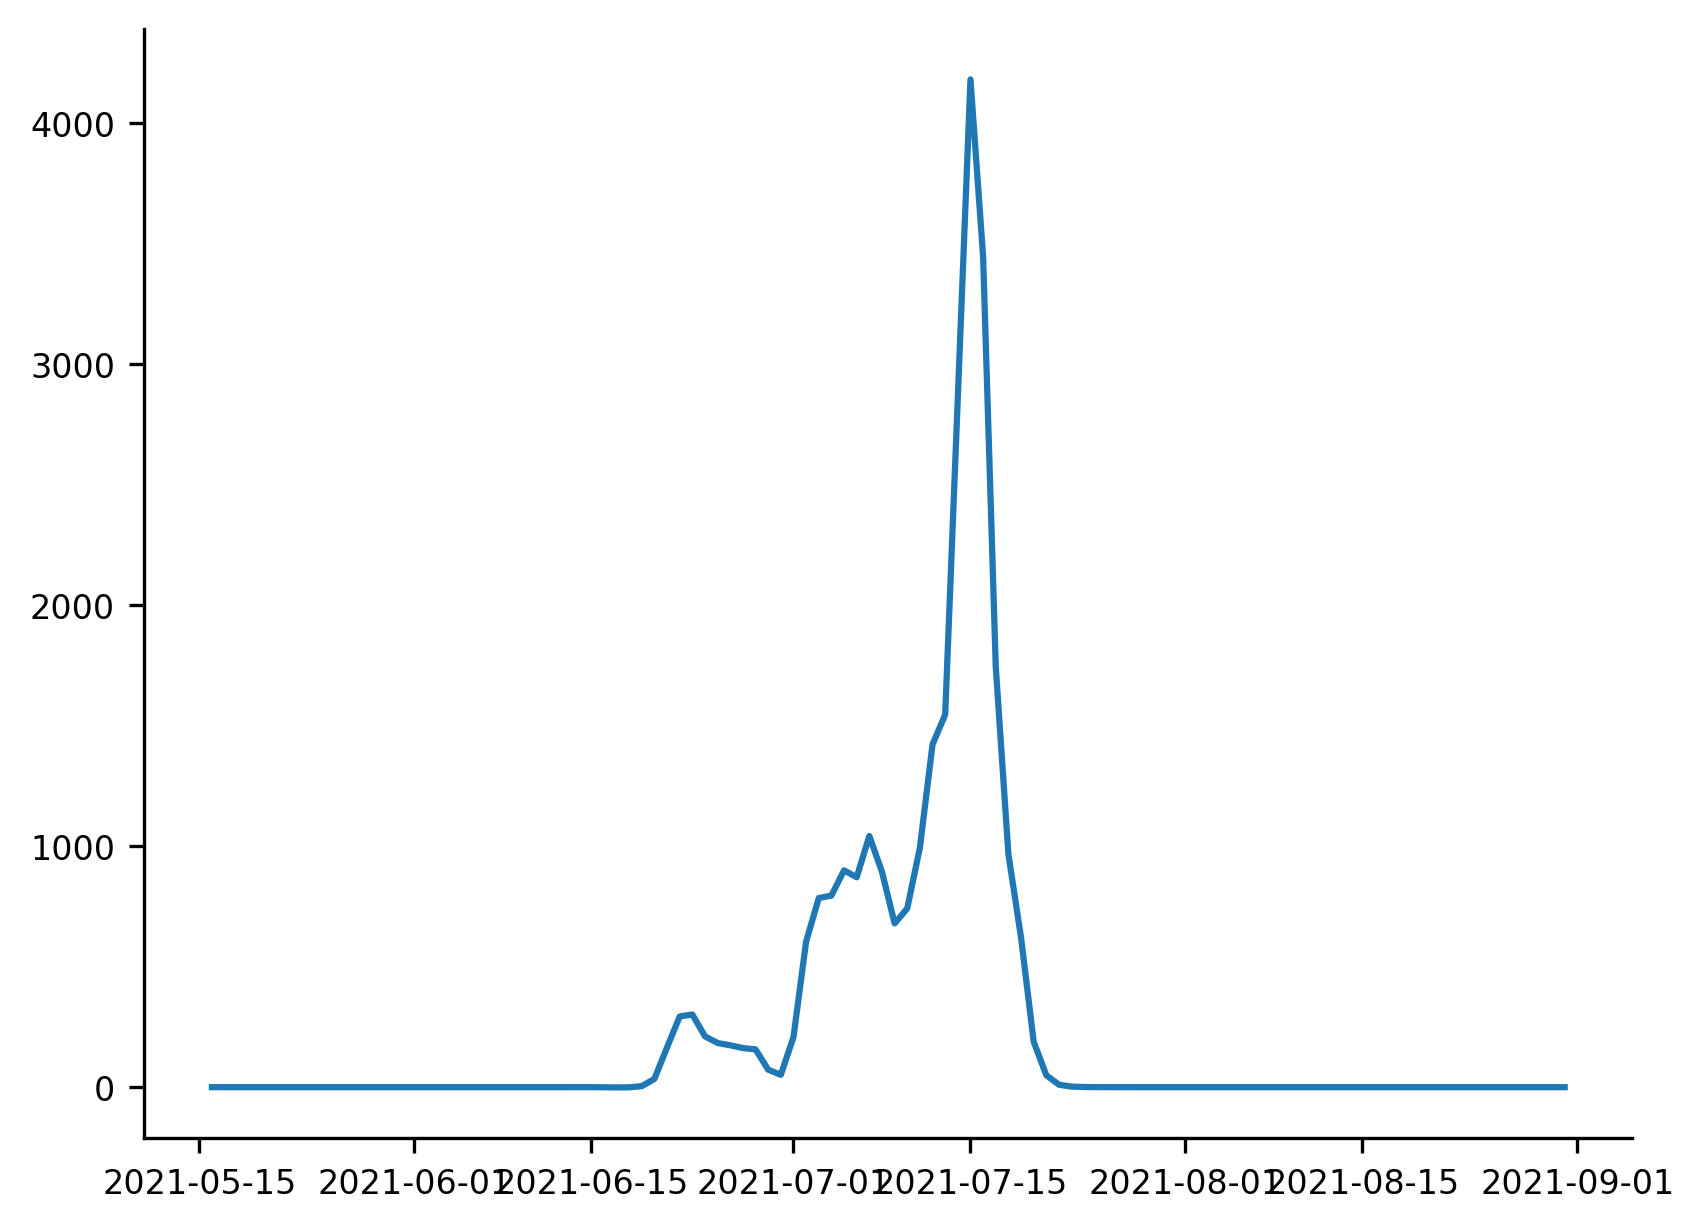

In [86]:
plt.plot(x,y[1])
plt.show()

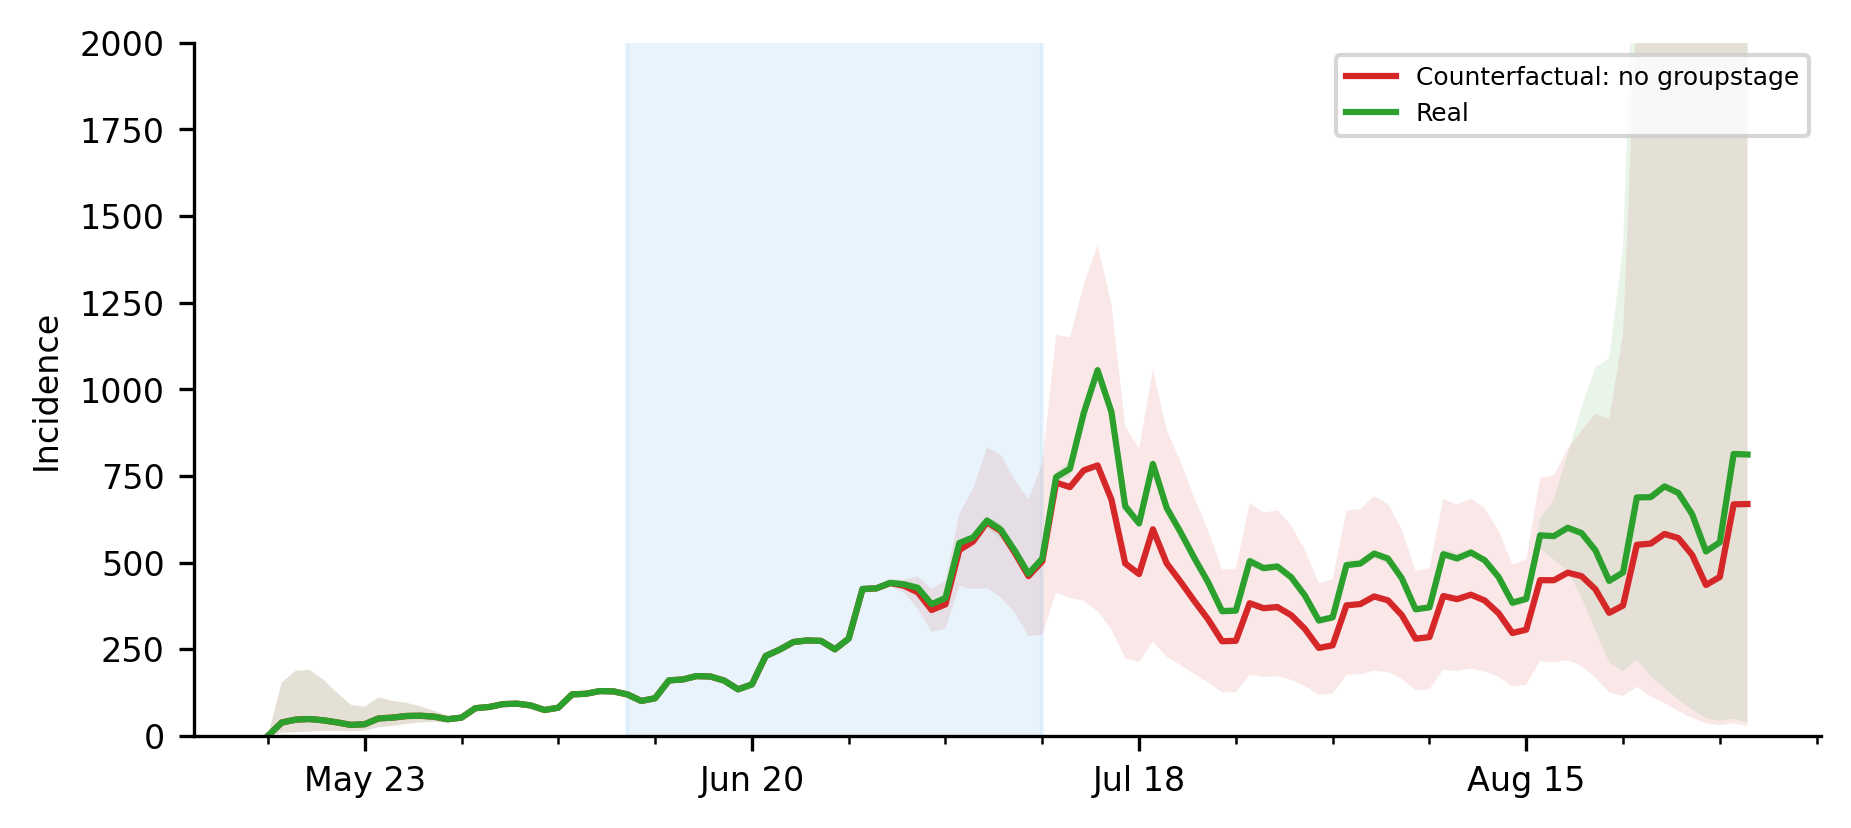

In [31]:

new_cases_no_GS = get_from_trace("new_cases",prediction_no_GS,from_type="predictions")
new_cases_normal = get_from_trace("new_cases",traces[0])
x = pd.date_range(models[0].sim_begin,models[0].sim_end)

fig, ax = plt.subplots(1,1,figsize=(7,3))
_timeseries(
    x=x,
    y=(new_cases_no_GS[:, :, 0] + new_cases_no_GS[:, :, 1])
    / (dls[0].population[0, 0] + dls[0].population[1, 0])
    * 1e6,  # incidence
    what="model",
    ax=ax,
    color="tab:red",
    label="Counterfactual: no groupstage"
)
_timeseries(
    x=x,
    y=(new_cases_normal[:, :, 0] + new_cases_normal[:, :, 1])
    / (dls[0].population[0, 0] + dls[0].population[1, 0])
    * 1e6,  # incidence
    what="model",
    ax=ax,
    label="Real"
)
# Plot shaded uefa
_uefa_range(ax)
ax.set_ylabel("Incidence")
format_date_axis(ax)
ax.legend()
#ax.set_xlim(*xlim_ts)
ax.set_ylim(0,2000)
plt.show()

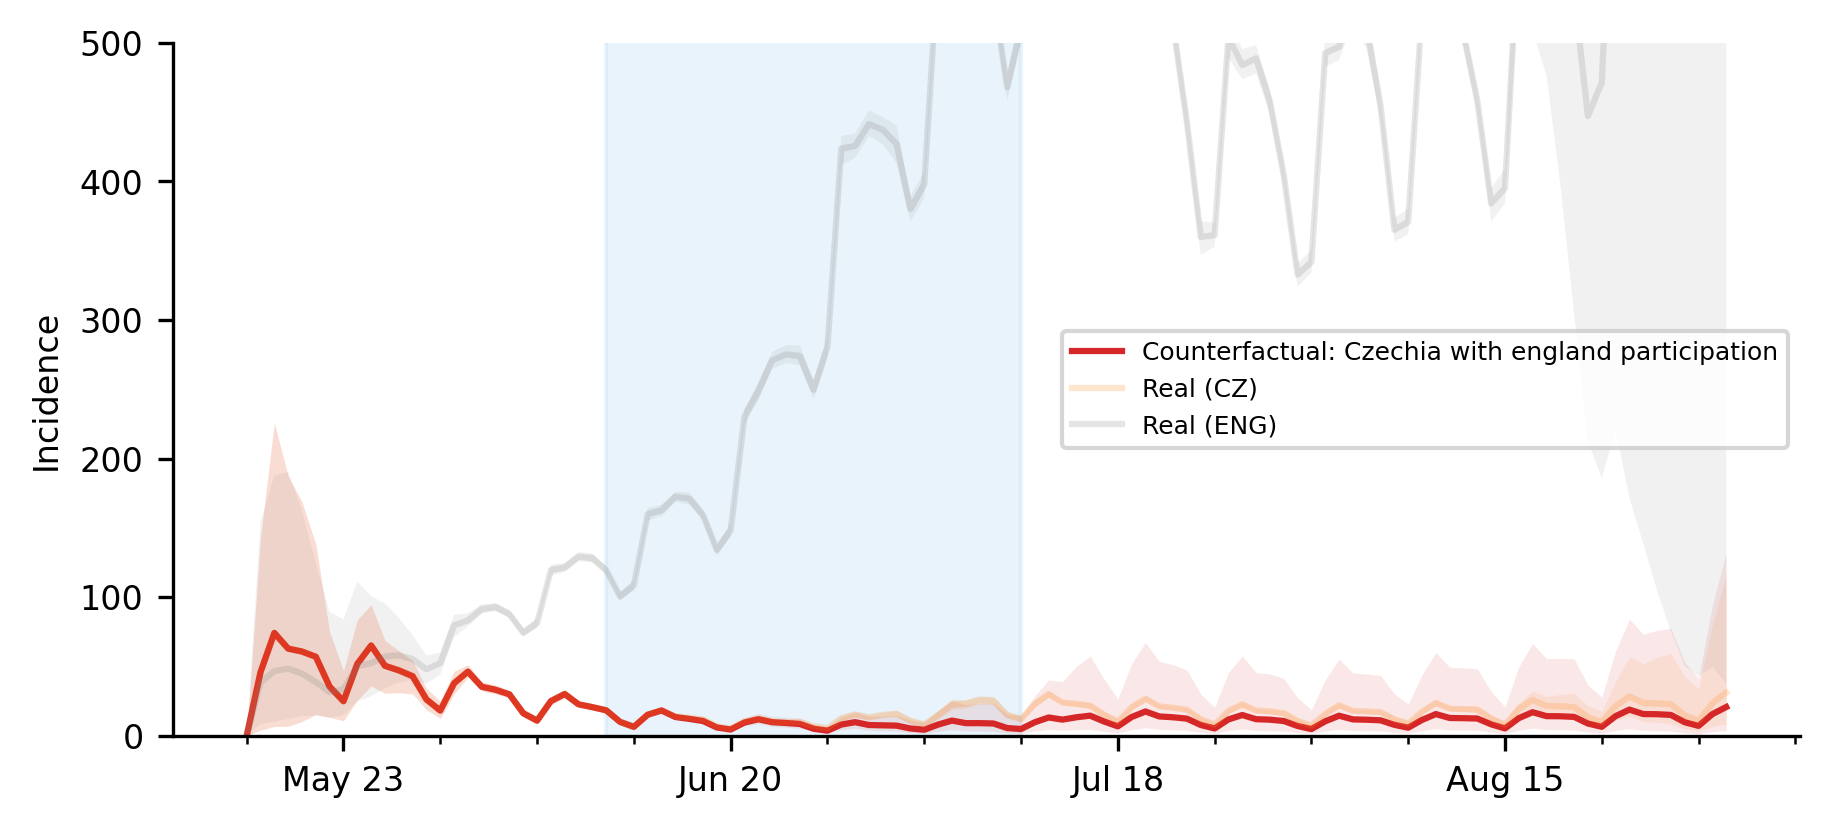

In [126]:
## Plotting
from covid19_soccer.plot.timeseries import _uefa_range, incidence, stacked_filled, fraction_male_female, _timeseries, format_date_axis

new_cases_cz_with_eng_part = get_from_trace("new_cases",prediction_czechia_with_england_participation,from_type="predictions")
new_cases_normal_eng = get_from_trace("new_cases",traces[0])
new_cases_normal_cz = get_from_trace("new_cases",traces[1])
x = pd.date_range(models[0].sim_begin,models[0].sim_end)

fig, ax = plt.subplots(1,1,figsize=(7,3))
_timeseries(
    x=x,
    y=(new_cases_cz_with_eng_part[:, :, 0] + new_cases_cz_with_eng_part[:, :, 1])
    / (dls[1].population[0, 0] + dls[1].population[1, 0])
    * 1e6,  # incidence
    what="model",
    ax=ax,
    color="tab:red",
    label="Counterfactual: Czechia with england participation"
)

_timeseries(
    x=x,
    y=(new_cases_normal_cz[:, :, 0] + new_cases_normal_cz[:, :, 1])
    / (dls[1].population[0, 0] + dls[1].population[1, 0])
    * 1e6,  # incidence
    what="model",
    color="tab:orange",
    ax=ax,
    label="Real (CZ)",
    alpha=0.2
)
_timeseries(
    x=x,
    y=(new_cases_normal_eng[:, :, 0] + new_cases_normal_eng[:, :, 1])
    / (dls[0].population[0, 0] + dls[0].population[1, 0])
    * 1e6,  # incidence
    what="model",
    color="tab:gray",
    ax=ax,
    label="Real (ENG)",
    alpha=0.2
)


# Plot shaded uefa
_uefa_range(ax)
ax.set_ylabel("Incidence")
format_date_axis(ax)
ax.legend()
#ax.set_xlim(*xlim_ts)
ax.set_ylim(0,500)
plt.show()

<xarray.DataArray 'alpha_mean' ()>
array(0.77379087)